# COS 598 Image Processing Spring 2022 HW4: Demonstrating Frequency and Scale - Creating a Hybrid Image

### By: Nicholas Soucy

## Imports

In [2]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import misc
from scipy import ndimage
import math
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps, ImageChops
from matplotlib.colors import LogNorm
%matplotlib inline

## Hybrid Image Creation

I found this nice guide on the internet that explained the overall process on a high level with some code implementation. Therefore I would like to give credit to this website for helping develop the hybrid images you see in this notebook.
Guide: https://jeremykun.com/2014/09/29/hybrid-images/

### Show Images

#### Import original Images

For this homework, I have decided to use a picture of me and my fiance Paige.

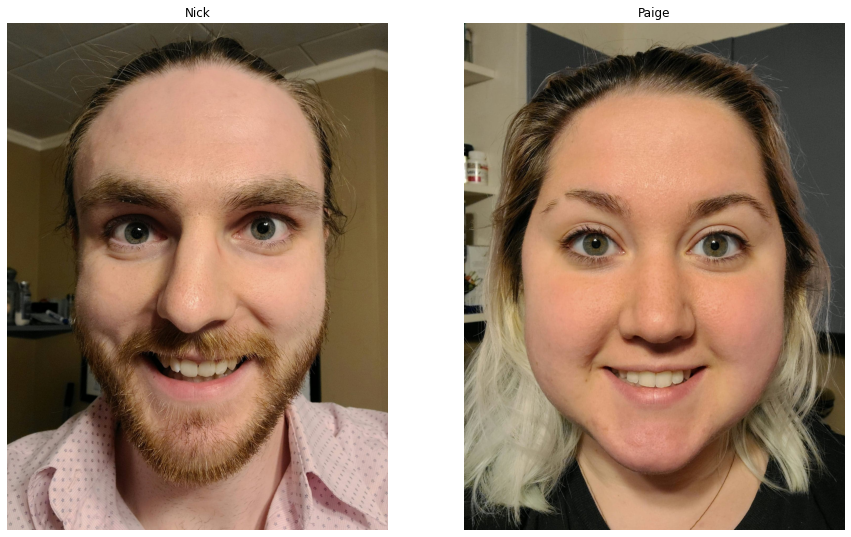

Nick Picture Shape:  (1536, 2048)
Paige Picture Shape:  (1446, 1928)


In [3]:
img = Image.open('nick.jpg')

img2 = Image.open('paige.jpg')

#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(img2, cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

print("Nick Picture Shape: ",img.size)
print("Paige Picture Shape: ",img2.size)

#### Crop and Resize Images

For better hybrid image creation, lets get our eyes to line up by offsetting Paige's image.

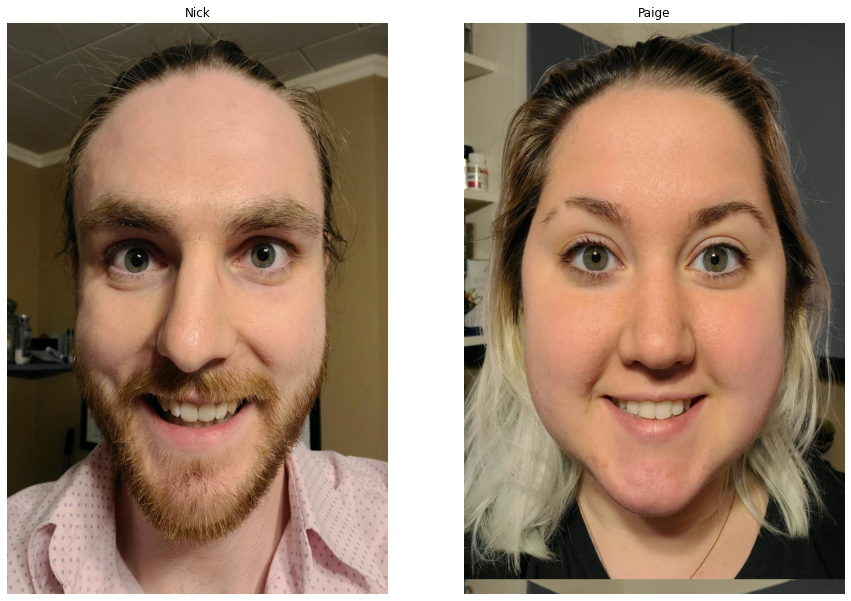

Nick Picture Shape:  (1200, 1800)
Paige Picture Shape:  (1200, 1800)


In [4]:
img2 = ImageChops.offset(img2, 0, -50)

Nimg = img.resize((1200, 1800))   # image resizing

Nimg2 = img2.resize((1200, 1800))


#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Nimg, cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(Nimg2, cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

print("Nick Picture Shape: ",Nimg.size)
print("Paige Picture Shape: ",Nimg2.size)

#### Convert to Grayscale OpenCV

Now that everything is the same size and our eyes are lined up, we can convert the pillow RBG images into opencv grayscale.

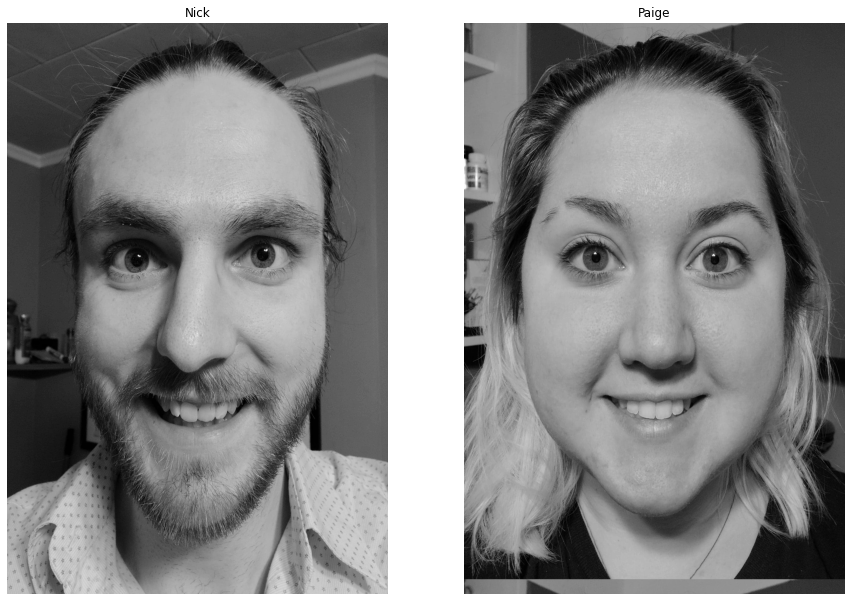

Nick Picture Shape:  (1800, 1200)
Paige Picture Shape:  (1800, 1200)


In [5]:
nick = cv2.cvtColor(np.array(Nimg), cv2.COLOR_RGB2GRAY)
paige = cv2.cvtColor(np.array(Nimg2), cv2.COLOR_RGB2GRAY)

#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(nick, cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(paige, cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

print("Nick Picture Shape: ",nick.shape)
print("Paige Picture Shape: ",paige.shape)

### Hybrid Image Creation

#### Hybrid Image Explaination

The general idea behind Hybrid Images is to add one low-pass filtered image and one high-pass filtered image together. This way, the features that an observer sees is dependent on image's scale. 

To achieve a low-pass and high-pass filter on our images, we use fast fourier transforms to transfer our images to frequency space. This allows us to sepearte low and high frequency components using a filter.

For our filter, we can use our trusty Gaussian function. If we’re trying to get rid of high-frequency components (called a “low-pass filter”), we can just multiply the Fourier coefficients directly by the filter values g(x,y), and if we’re doing a “high-pass filter” we multiply by 1 - g(x,y).

After this, we do a reverse Fourier transform to get back to the original image space with the frequencies we want removed. Then we add the two resulting images together to get our hybrid image.

Now lets impliment this pipeline one step at a time:

#### Starting Images

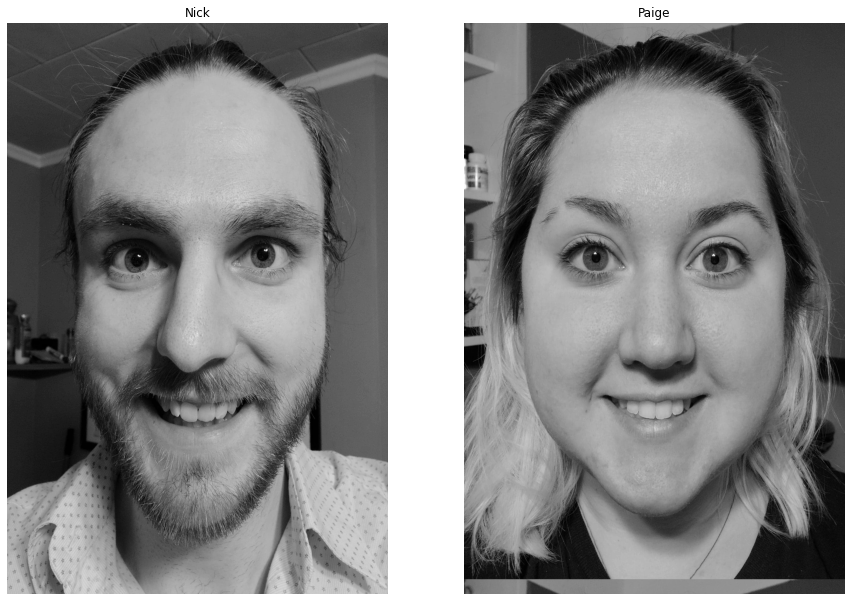

In [6]:
#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(nick, cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(paige, cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

#### Fourier Transform

Now we convert our images to Fourier frequency space.

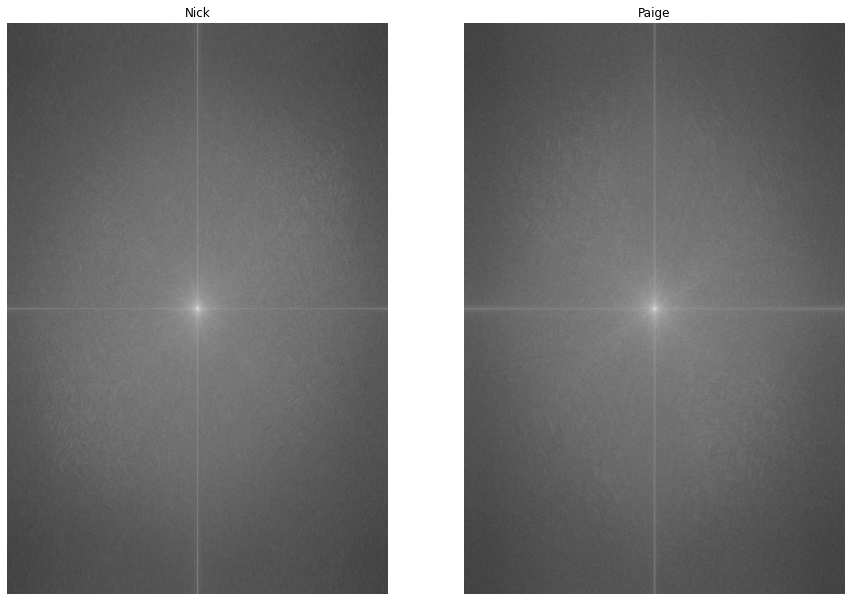

In [7]:
#Compute Fourier Transforms
fourier_nick = fftshift(fft2(nick))
fourier_paige = fftshift(fft2(paige))

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(np.abs(fourier_nick),norm=LogNorm(vmin=5),cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(np.abs(fourier_paige),norm=LogNorm(vmin=5),cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

#### Filtering Images

Now that we have the images in frequency space, we can filter the high and low frequencies. We will do a high-pass filter on the 'nick' image and the low-pass filter on the 'paige' image. 

This is where more of the tweaking in the pipline is done. The sigma for the gaussian kernal for each image is important and changes the image greatly. If the sigma is too low, not enough of the features will be removed and the image will dominate the hybrid image in all scales, if the sigma is too high, the image will be washed out in all scales and difficult to see. 

For this particular implimentation, we found that having the 'nick' image be high-passed witha sigma = 18 and the 'paige' image be low-passed with sigma = 20 resulted in a good hybrid image.

In [8]:
#Gaussian Filter Function
def GaussianFilter(dim_x, dim_y, sigma, high_pass=True):
    x_0 = int(math.ceil(dim_x/2))
    y_0 = int(math.ceil(dim_y/2))

    def gaussian(x,y):
        coefficient = math.exp(-1.0 * ((x - x_0)**2 + (y - y_0)**2) / (2 * sigma**2))

        if(high_pass):
            return 1-coefficient
        else:
            return coefficient

    return np.array([[gaussian(x,y) for y in range(dim_y)] for x in range(dim_x)])

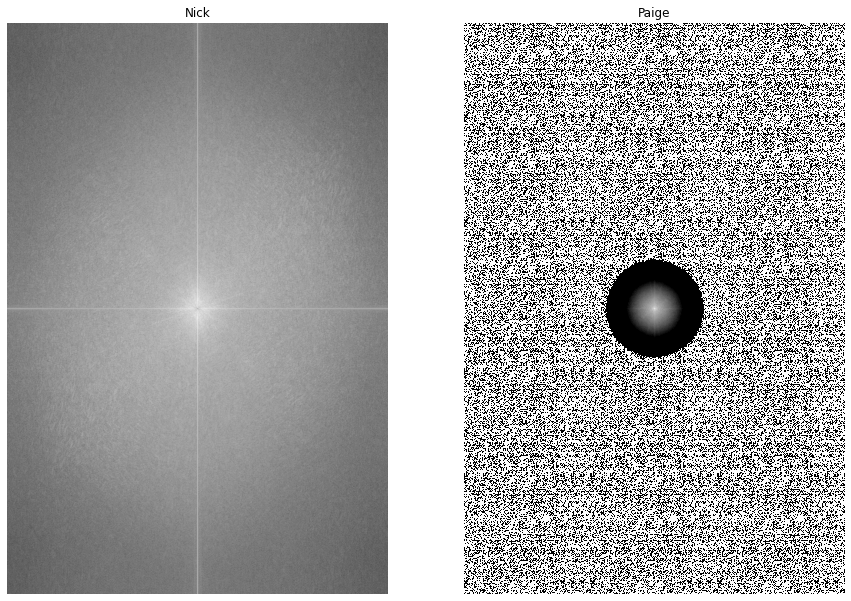

In [9]:
#Apply filters to image
n,m = fourier_nick.shape
filtered_fourier_nick = fourier_nick * GaussianFilter(n, m, 18, high_pass=True)
filtered_fourier_paige = fourier_paige * GaussianFilter(n, m, 20, high_pass=False)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(np.abs(filtered_fourier_nick),norm=LogNorm(vmin=5),cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(np.abs(filtered_fourier_paige),norm=LogNorm(vmin=5),cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

Then we can do a reverse fourier transform to get them back into the image space.

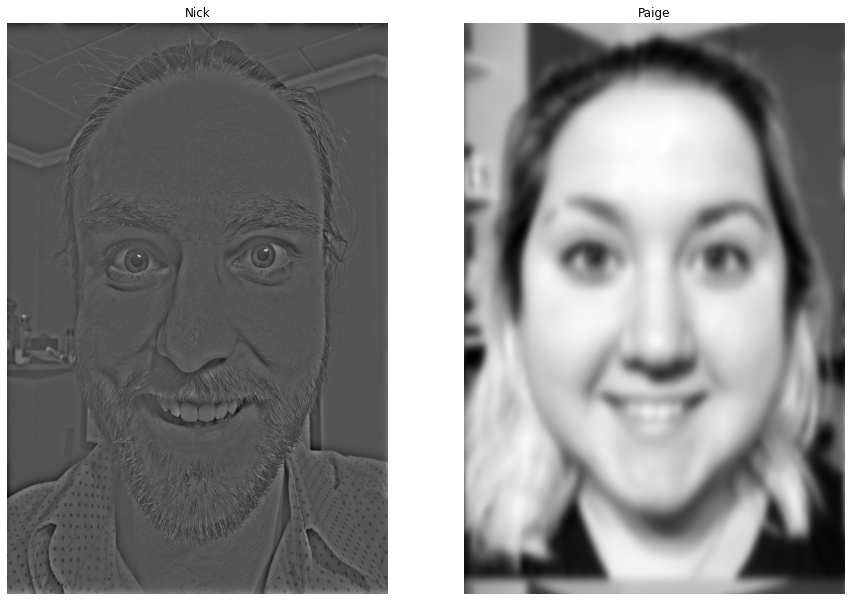

In [10]:
#apply reverse fourier transforms
nick_filtered = ifft2(ifftshift(filtered_fourier_nick))
paige_filtered = ifft2(ifftshift(filtered_fourier_paige))


f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(nick_filtered.real,cmap='gray')
axarr[0].set_title("Nick")
axarr[0].axis('off')
axarr[1].imshow(paige_filtered.real,cmap='gray')
axarr[1].set_title("Paige")
axarr[1].axis('off')
plt.show()

#### Final Hybrid Image

Now that our two filtered images are done, we can add them together to get our final hybrid image!

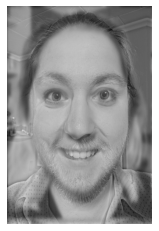

In [16]:
hybrid_img = nick_filtered + paige_filtered
fig = plt.figure()
plt.imshow(hybrid_img.real,cmap='gray')
plt.axis('off')
fig.savefig('NP_Hybrid_Image.jpg',dpi=500,transparent=True,bbox_inches='tight',pad_inches=0)
plt.show()

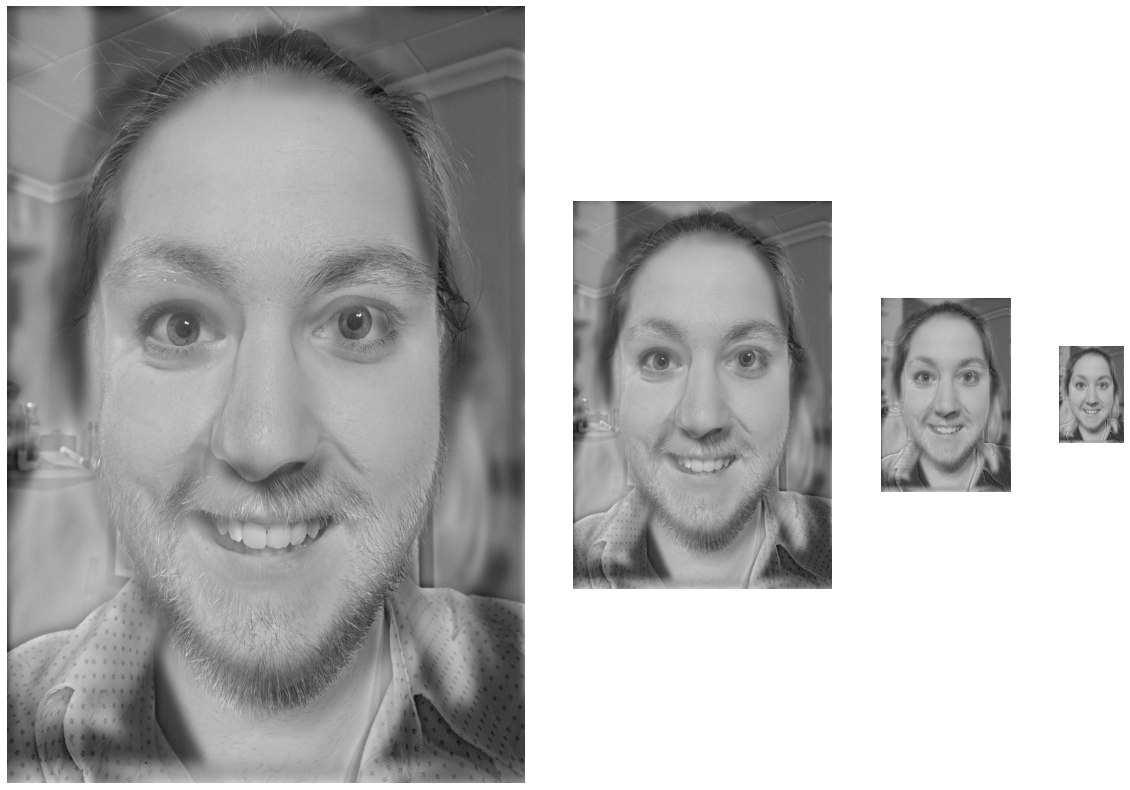

In [11]:
#add both images
hybrid_img = nick_filtered + paige_filtered

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()

### Playing with Parameters

Now that we have the final image, I wanted to continue having fun playing with different sigmas for the filters and a few other things. Thought I might as well include it in the assignment.

#### Image Functions

For ease of hybrid image creation, I have compiled the previous steps into functions that we can call to create the image:

In [13]:
def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = fftshift(fft2(imageMatrix))
    filteredDFT = shiftedDFT * filterMatrix
    return ifft2(ifftshift(filteredDFT))

def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, GaussianFilter(n, m, sigma, high_pass=False))

def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, GaussianFilter(n, m, sigma, high_pass=True))

def hybridImage(highFreqImg, lowFreqImg, sigmaHigh, sigmaLow):
    highPassed = highPass(highFreqImg, sigmaHigh)
    lowPassed = lowPass(lowFreqImg, sigmaLow)

    return highPassed + lowPassed

We can use these functions to easily create our original hybrid image from before with the original images:

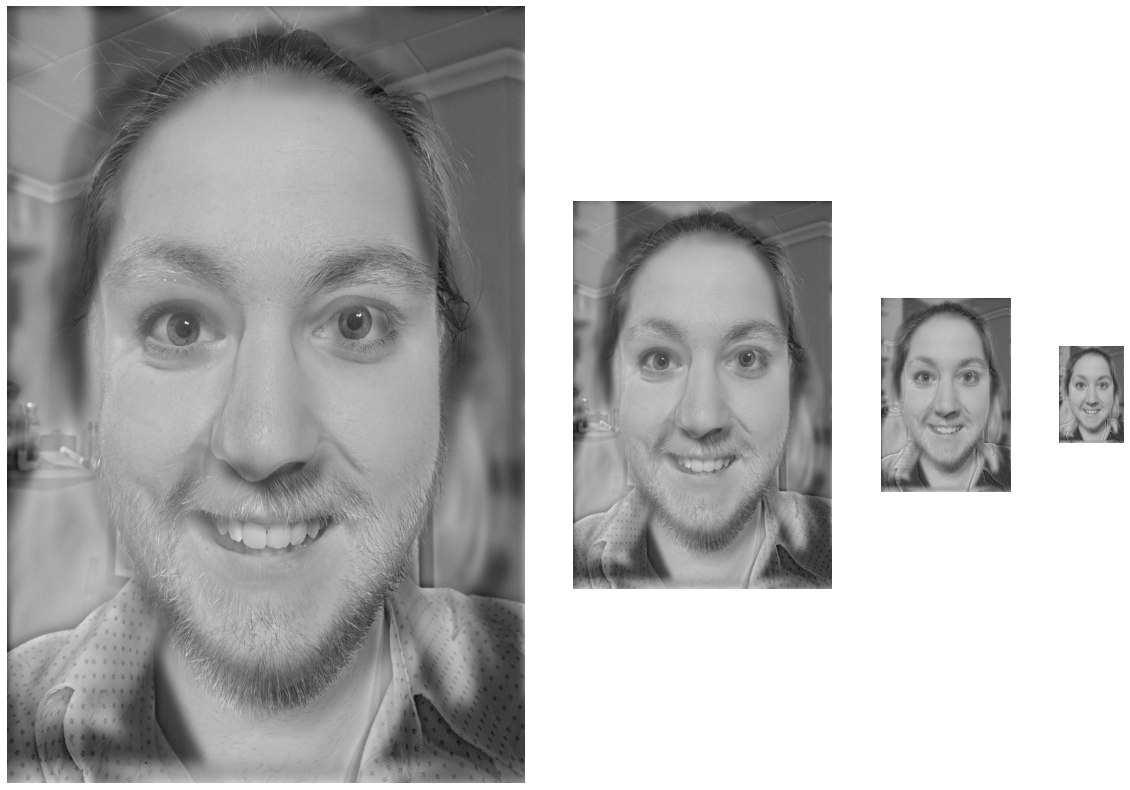

In [18]:
hybrid_img = hybridImage(nick,paige,18,20)

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()

#### Switching Low-pass and High-pass Images

My first thought was perhaps we can improve the image by switching which image is low-passed and high-passed. Lets show that result below: 

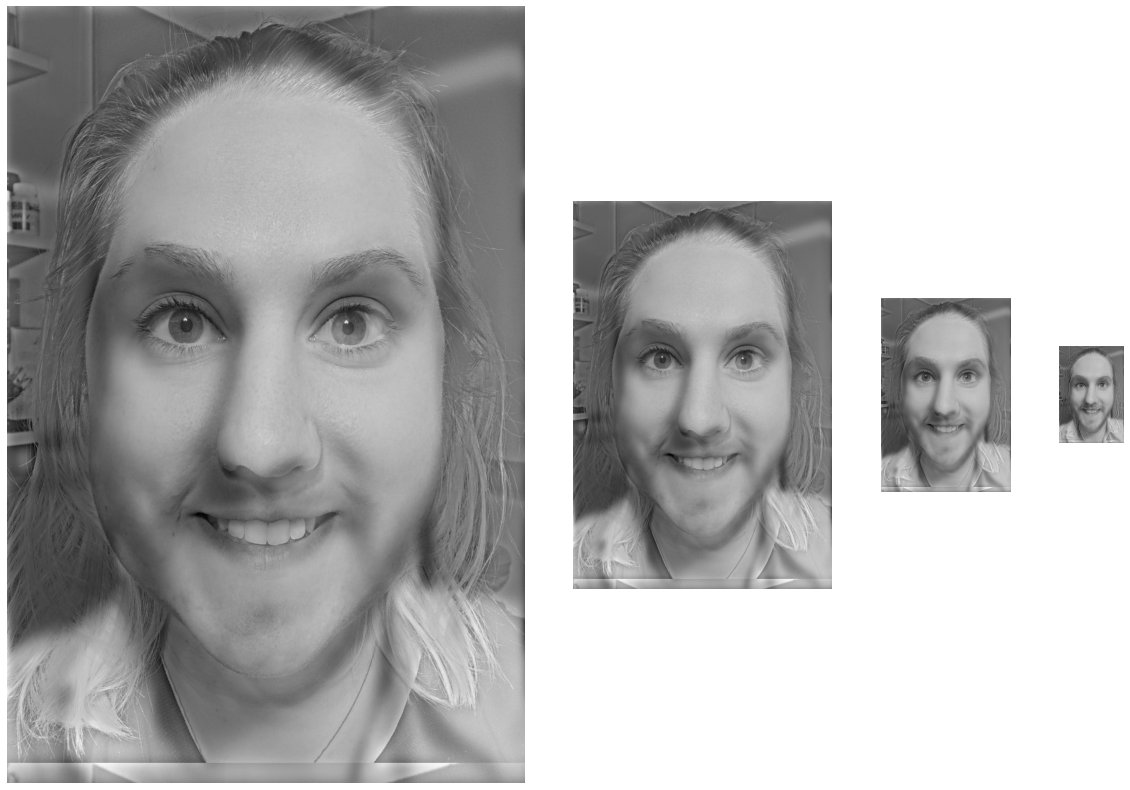

In [19]:
hybrid_img = hybridImage(paige,nick,20,18)

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()

As you can see, once there is no hell deep enough to bury this image, it was a good move to have the 'nick' image high-passed and the 'paige' image low-passed.

I suspect that the stunning lack of beard on my fiance causes this. I beleive the beard is better when it is the high-passed image. It gives my fiance a lot of five-o-clock shadow when it is the low-passed image.

#### Playing with Sigma

As for the last informal experiment, I had a hard time finding a good sigma for the 'nick' image. I found that high sigmas resulted in the features of that image being 'washed-out' in the hybrid image, but with a low sigma, the features will dominate the other image. With the beard, it was quite tricky to find a good sigma. Here are some of the failed sigma experiments below: 

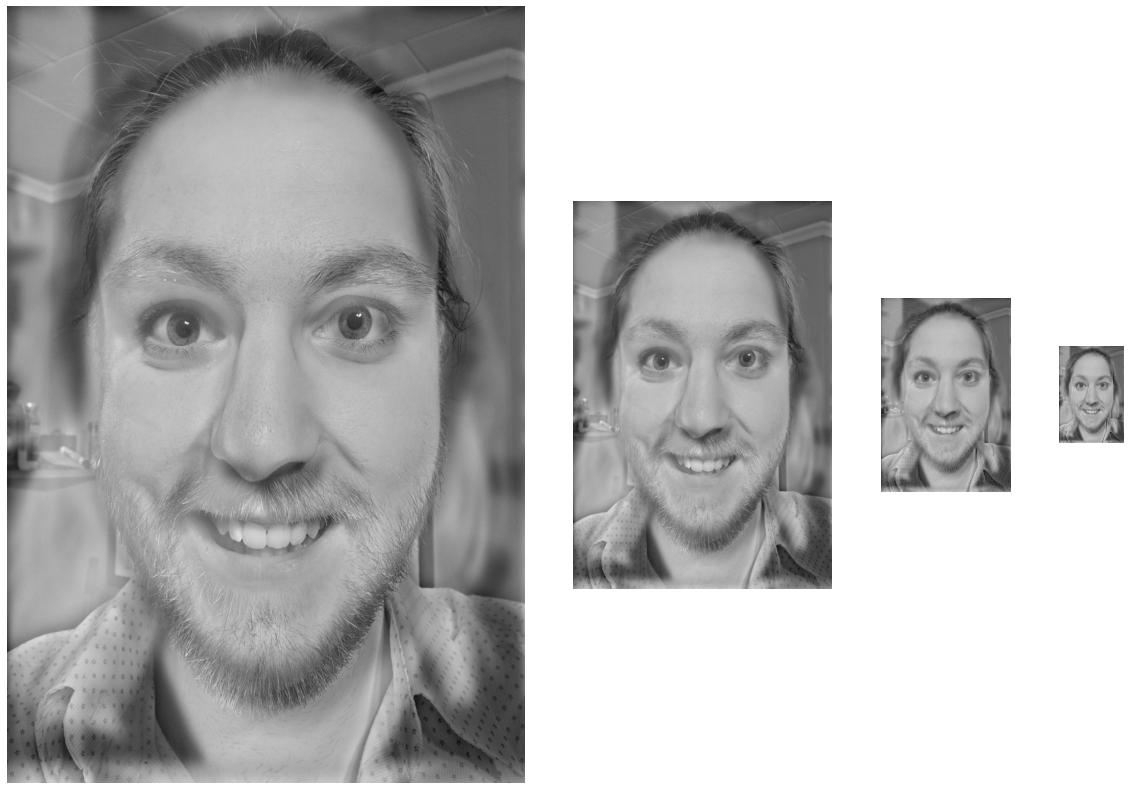

In [20]:
hybrid_img = hybridImage(nick,paige,12,20)

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()

As you can see with the lower sigma for the 'nick' image, my beard and face shape dominate on all scales.

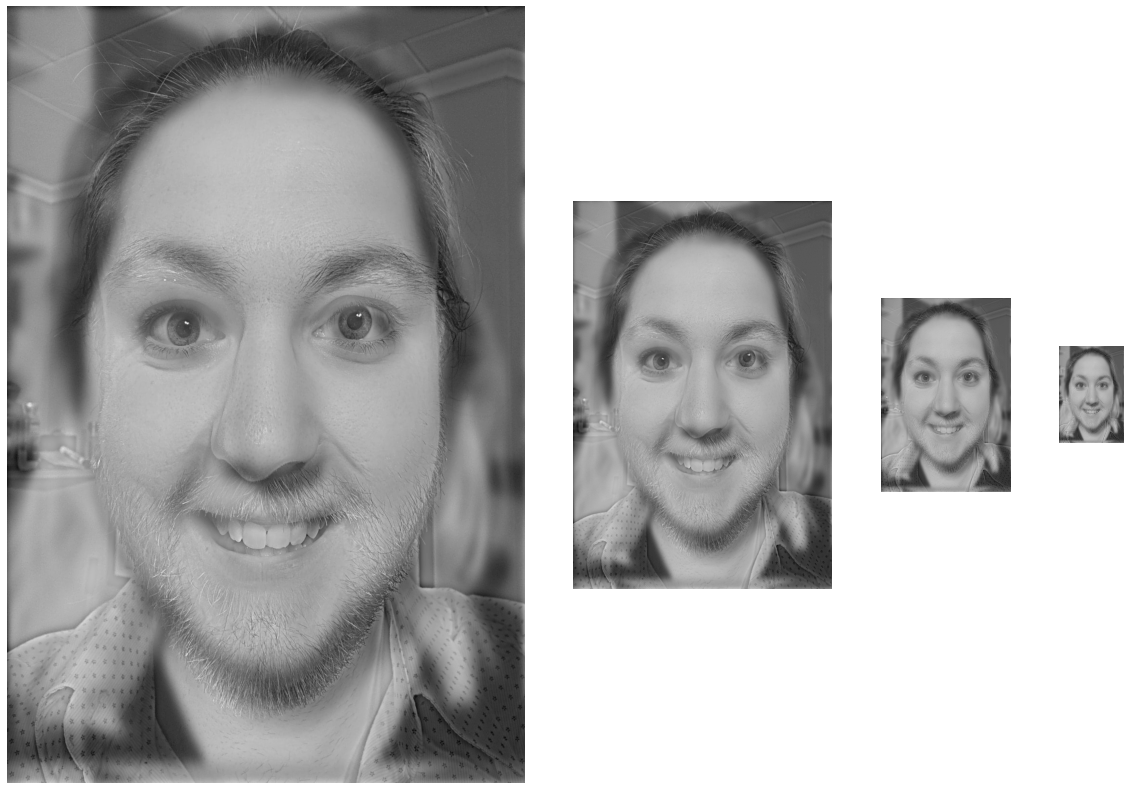

In [21]:
hybrid_img = hybridImage(nick,paige,30,20)

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()

With higher values of sigma however, Paige's face shape dominates at each scale, even though my beard is still visible in the larger scales, it looks more like Paige has a beard rather than me.

Therefore, I found the Nick sigma = 18 and Paige sigma = 20 to be a good medium:

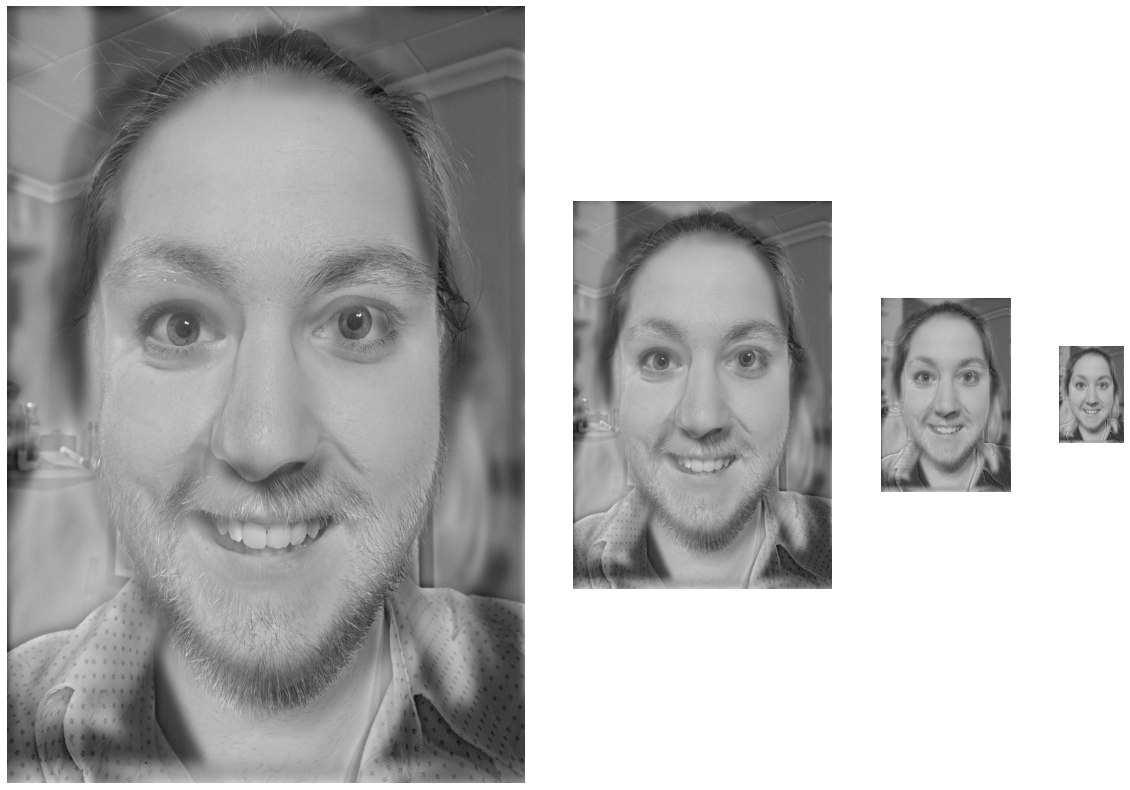

In [22]:
hybrid_img = hybridImage(nick,paige,18,20)

#Show all images
f, axarr = plt.subplots(1,4,gridspec_kw={'width_ratios': [24,12,6,3]},figsize=(20,20))
axarr[0].imshow(hybrid_img.real, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(hybrid_img.real, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(hybrid_img.real, cmap='gray')
axarr[2].axis('off')
axarr[3].imshow(hybrid_img.real, cmap='gray')
axarr[3].axis('off')
plt.show()